# Generate R-Net train&eval data list
The purpose of this notebook is to get a txt file in the format of<br><br>

`image path`||`label`+`x1` `y1` `x2` `y2`+`x1^` `y1^` `x2^` `y2^`+`d x_lefteye` `d y_lefteye` `d x_righteye` `d y_righteye`......\n<br>
......<br>

Here, `x1^` `y1^` `x2^` `y2^` is the coordinate of a valid predicted box generated by P-Net, `x1` `y1` `x2` `y2` is the coordinate of the true box, and `d x_lefteye` `d y_lefteye` is landmark offset. With these information prepared beforehand, when R-Net is loading data, the offset can be calculated and the image can be cropped from the image instantaneously. <br>

example:<br>
```
../input/celeba-original-wild-images/Part 17/Part 17/162798.jpg||pf+52 36 218 266+73 72 244 243+0.1754 0.2748 0.5087 0.2865 0.3274 0.4970 0.2163 0.6491 0.4970 0.6374|...
```

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
from PIL import Image
import os.path as osp
import numpy as np
from numpy.random import uniform
import PIL
from PIL import Image, ImageDraw
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import math
import random
import argparse
import os
import copy
import json
import warnings
warnings.filterwarnings("ignore")

### get box & landmark data

In [2]:
root =  '../input/celeba-original-wild-images/'

def getlandmark(phase):
    result = []
    beg,end = {'train': (0,162770), 'val': (162770,182637), 'test': (182637,202599)}.get(phase)
    
    boxes_frame = pd.read_csv('../input/celeba-original-wild-images/list_bbox_celeba.csv')
    landmarks_frame = pd.read_csv('../input/landmark/list_landmarks_celeba.csv')
        
    for n in range(beg,end):
        
        name = landmarks_frame.iloc[n, 0]

        part = int(name[:2]) if name[2:6]=='0000' else int(name[:2])+1
        full_path = root+'Part '+str(part)+'/Part '+str(part)+'/'+name
        try:
            img = Image.open(full_path)
        except:
            print('invalid image')
            continue
    
        ldmk = landmarks_frame.iloc[n, 1:]
        ldmk = np.asarray(ldmk, dtype=np.float32)
        
        box = boxes_frame.iloc[n, 1:]
        box = np.asarray(box,dtype=np.int64)
        
        result.append([full_path,box,ldmk])
        
    return result

### P-Net and R-Net

In [3]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)
        

class P_Net(nn.Module):
    def __init__(self):
        super(P_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(10, 16, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.PReLU()
        )
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1,)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        det = torch.sigmoid(self.conv4_1(x))
        box = self.conv4_2(x)
        landmark = self.conv4_3(x)
        return det, box, landmark

    
class R_Net(nn.Module):
    def __init__(self):
        super(R_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(28, 48, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 64, kernel_size=2, stride=1),
            nn.PReLU()
        )
        self.conv4 = nn.Linear(64 * 2 * 2, 128)
        self.prelu4 = nn.PReLU()
        self.conv5_1 = nn.Linear(128, 1)
        self.conv5_2 = nn.Linear(128, 4)
        self.conv5_3 = nn.Linear(128, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        det = torch.sigmoid(self.conv5_1(x))
        box = self.conv5_2(x)
        landmark = self.conv5_3(x)
        return det, box, landmark

In [4]:
def IoU(box, boxes):

    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[2] - boxes[0] + 1) * (boxes[3] - boxes[1] + 1)
    xx1 = np.maximum(box[0], boxes[0])
    yy1 = np.maximum(box[1], boxes[1])
    xx2 = np.minimum(box[2], boxes[2])
    yy2 = np.minimum(box[3], boxes[3])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = np.true_divide(inter,(box_area + area - inter))
    return ovr

In [5]:
def run_first_stage(image, net, scale, threshold):

    width, height = image.size
    sw, sh = math.ceil(width * scale), math.ceil(height * scale)
    img = image.resize((sw, sh), Image.BILINEAR)
    img = transforms.ToTensor()(img).unsqueeze(0)
    img = img.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    output = net(img)
    probs = output[0].data.cpu().numpy()[0, 0, :, :]
    offsets = output[1].data.cpu().numpy()
    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]

def _generate_bboxes(probs, offsets, scale, threshold):
    stride = 2
    cell_size = 12

    inds = np.where(probs > threshold)
    if inds[0].size == 0:
        return np.array([])
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    bounding_boxes = np.vstack([
        np.round((stride * inds[1] + 1.0) / scale),
        np.round((stride * inds[0] + 1.0) / scale),
        np.round((stride * inds[1] + 1.0 + cell_size) / scale),
        np.round((stride * inds[0] + 1.0 + cell_size) / scale),
        score, offsets
    ])
    return bounding_boxes.T

def nms(boxes, overlap_threshold=0.5, mode='union'):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        if mode is 'min':
            ovr = inter / np.minimum(areas[i], areas[order[1:]])
        else:
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlap_threshold)[0]
        order = order[inds + 1]
    return keep

In [6]:
def convert_to_square(bboxes):
    square_bboxes = np.zeros_like(bboxes)
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = np.maximum(h, w)
    square_bboxes[:, 0] = x1 + w * 0.5 - max_side * 0.5
    square_bboxes[:, 1] = y1 + h * 0.5 - max_side * 0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0
    return square_bboxes


def calibrate_box(bboxes, offsets):

    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    w = np.expand_dims(w, 1)
    h = np.expand_dims(h, 1)

    translation = np.hstack([w, h, w, h]) * offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes


def get_image_boxes(bounding_boxes, img, size=24):
    num_boxes = len(bounding_boxes)
    width, height = img.size

    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bounding_boxes, width, height)
    img_boxes = np.zeros((num_boxes, 3, size, size), 'float32')

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3), 'uint8')
        img_array = np.asarray(img, 'uint8')
        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
            img_array[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]
        img_box = Image.fromarray(img_box)
        img_box = img_box.resize((size, size), Image.BILINEAR)
        img_box = np.asarray(img_box, 'float32')
        img_boxes[i, :, :, :] = img_normalization(img_box)

    return img_boxes


def correct_bboxes(bboxes, width, height):
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w, h = x2 - x1 + 1.0, y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]

    x, y, ex, ey = x1, y1, x2, y2
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0

    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0

    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0

    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0

    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0
    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]

    return return_list


def img_normalization(img):
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    img = (img - 127.5) * 0.0078125
    return img

The thresholds for P-Net is set to 0.85 and 0.5 to weed out more poorly predicted boxes.

In [7]:
THRESHOLDS = [0.85]
NMS_THRESHOLDS = [0.5]
MIN_FACE_SIZE = 15.0


def pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    pnet.eval()
    width, height = img.size
    min_length = min(height, width)
    min_detection_size = 12
    factor = 0.707  # sqrt(0.5)
    scales = []
    m = min_detection_size / min_face_size
    min_length *= m
    factor_count = 0
    while min_length > min_detection_size:
        scales.append(m * factor ** factor_count)
        min_length *= factor
        factor_count += 1

    bounding_boxes = []
    for s in scales:
        boxes = run_first_stage(img, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)

    bounding_boxes = [i for i in bounding_boxes if i is not None]

    try:
        _ = bounding_boxes[0]
    except Exception:
        img.show()
    if len(bounding_boxes) == 0:
        return None
    bounding_boxes = np.vstack(bounding_boxes)

    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    return bounding_boxes


def rnet_boxes(img, rnet, bounding_boxes, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    rnet.eval()
    img_boxes = get_image_boxes(bounding_boxes, img, size=24)
    img_boxes = torch.FloatTensor(img_boxes)
    img_boxes=img_boxes.cuda()
    output = rnet(img_boxes)
    probs = output[0].data.cpu().numpy()
    offsets = output[1].data.cpu().numpy()

    
    keep = np.where(probs[:, 0] > thresholds[1])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 0].reshape((-1,))
    offsets = offsets[keep]
    
    
    keep = nms(bounding_boxes, nms_thresholds[1])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    
    
    return bounding_boxes

In [8]:
def calibrate_landmarks(self, bboxes, landmarks, align=False):
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    w = torch.unsqueeze(w, 1)
    h = torch.unsqueeze(h, 1)

    translation = torch.cat([w]*5 + [h]* 5, 1).float() * landmarks
    if align:
        landmarks = torch.ceil(translation).int()
    else:
        landmarks = torch.stack([bboxes[:, 0]] * 5 + [bboxes[:, 1]] * 5, 1) + torch.round(translation).int()
    return landmarks

## Visualize performance of P-Net and R-Net

In [9]:
global DEVICE
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    

pnet=P_Net().cuda()
pnet.load_state_dict(torch.load('../input/mtcnn2/PNl_bd_1.pth'))
# rnet=R_Net().cuda()
# rnet.load_state_dict(torch.load('../input/mtcnn2/RNlm_1s.pth'))


trainset = getlandmark('train')
evalset = getlandmark('val')

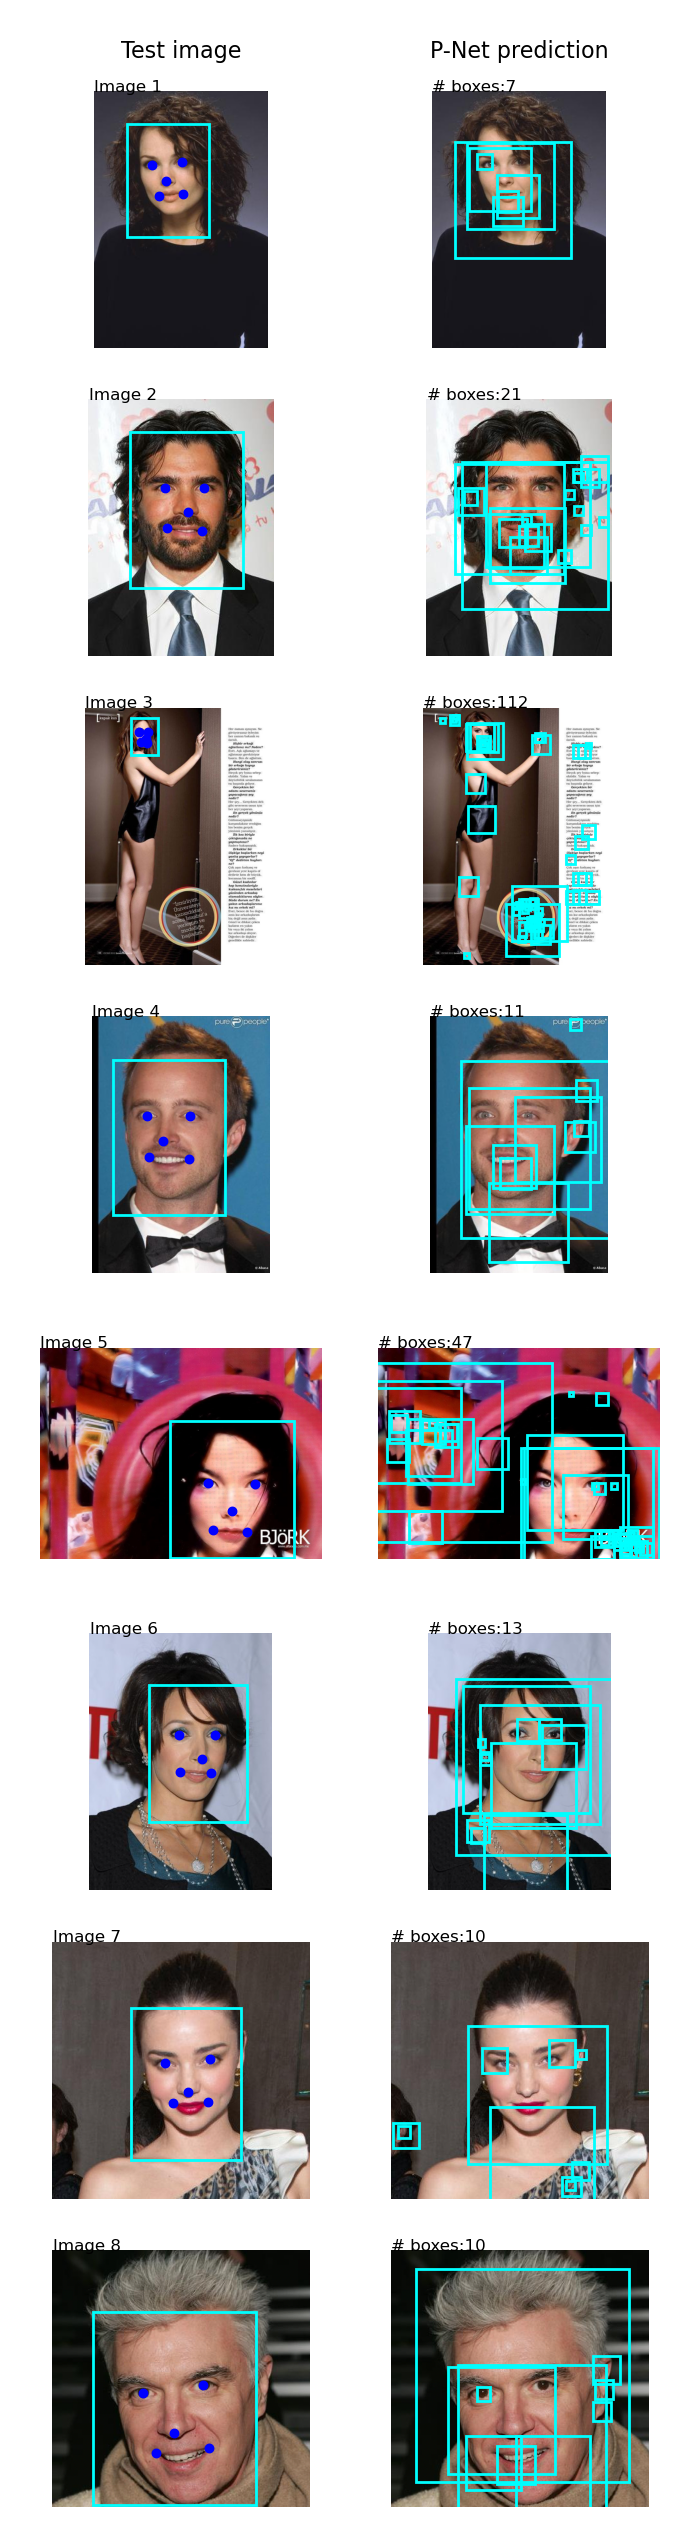

In [10]:
num_demo = 8
fig, ax = plt.subplots(num_demo,2,dpi = 400, figsize=(2,num_demo))

for i in range(num_demo):
    img_pth, box, landmark = evalset[i]
    
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet)
    if p_bounding_boxes is None:
        print(i)
        continue
    ldmk = np.array(landmark).reshape(-1,2)
#     r_bounding_boxes = rnet_boxes(img, rnet, p_bounding_boxes)
    

    ax[i,0].imshow(img)
    ax[i,0].text(0, 0, 'Image '+str(i+1),fontsize=3)
    ax[i,0].add_patch(plt.Rectangle((box[0], box[1]), box[2], box[3], fill=False, edgecolor='cyan',linewidth=0.5))
    ax[i,0].scatter(ldmk[:,0],ldmk[:,1], c='b',s=0.6)
    
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:60]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor='cyan',linewidth=0.5))   
    
#     ax[i,2].imshow(img)
#     ax[i,2].text(0, 0, '# boxes:'+str(len(r_bounding_boxes)),fontsize=3)
#     for b in r_bounding_boxes:
#         ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor='cyan',linewidth=0.5))


for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Test image",fontsize=4)
ax[0][1].set_title("P-Net prediction",fontsize=4)
# ax[0][2].set_title("R-Net prediction",fontsize=4)
fig.show()
# fig.savefig('demo_test_bad.png')

##  generate training & evaluation data for O-Net


In [11]:
def cal_landmark_offset(box, ldmk):
    minx, miny = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ldmk_offset = [(ldmk[i] - [minx, miny][i % 2]) / float([w, h][i % 2]) for i in range(len(ldmk))]
    return ldmk_offset

In [12]:
onet_train_data = open('/kaggle/working/rnet_train_celebA.txt','w')


iou_th = {'n': (0, 0.3), 'pf': (0.4, 0.65), 'p': (0.65, 1.0)}
since = time.time()

for num,(img_pth, face, landmark) in enumerate(trainset):
    if num%100==0:
        print('working on '+str(num))    
        
        
    try:
        i = Image.open(img_pth)
    except:
        continue
        
    image = Image.open(img_pth)
    bounding_boxes = pnet_boxes(image, pnet)
    if bounding_boxes is None:
        continue
    
    face[2] += face[0]
    face[3] += face[1]
    
    width, height = image.size
    total = len(bounding_boxes)
    
    onet_train_data.write(img_pth+'|')
    for id, box in enumerate(bounding_boxes, start=1):
        box = [min(max(0, int(box[i])), width if i % 2 == 0 else height) for i in range(4)]
        if box[2] - box[0] < 24: continue
        iou = IoU(box, face)
        
        for temp_label in iou_th:
            if iou < iou_th[temp_label][0] or iou > iou_th[temp_label][1]:
                continue
            else:
                label = temp_label
                ldmk_offset = ' '.join([str(i) for i in cal_landmark_offset(box, landmark)])
                gt_box = ' '.join([str(i) for i in face]) 
                crop_box = ' '.join([str(i) for i in box]) 
                
                onet_train_data.write('|'+label+'+'+gt_box+'+'+crop_box+'+'+ldmk_offset)
    onet_train_data.write('\n')
onet_train_data.close()

spent = time.time() - since
print('Complete in {:.0f}m {:.0f}s'.format(spent // 60, spent % 60))

working on 0
working on 100
working on 200
working on 300
working on 400
working on 500
working on 600
working on 700
working on 800
working on 900
working on 1000
working on 1100
working on 1200
working on 1300
working on 1400
working on 1500
working on 1600
working on 1700
working on 1800
working on 1900
working on 2000
working on 2100
working on 2200
working on 2300
working on 2400
working on 2500
working on 2600
working on 2700
working on 2800
working on 2900
working on 3000
working on 3100
working on 3200
working on 3300
working on 3400
working on 3500
working on 3600
working on 3700
working on 3800
working on 3900
working on 4000
working on 4100
working on 4200
working on 4300
working on 4400
working on 4500
working on 4600
working on 4700
working on 4800
working on 4900
working on 5000
working on 5100
working on 5200
working on 5300
working on 5400
working on 5500
working on 5600
working on 5700
working on 5800
working on 5900
working on 6000
working on 6100
working on 6200
work

In [13]:
onet_eval_data = open('/kaggle/working/rnet_eval_celebA.txt','w')

iou_th = {'n': (0, 0.3), 'pf': (0.4, 0.65), 'p': (0.65, 1.0)}
since = time.time()

for num,(img_pth, face, landmark) in enumerate(evalset):
    if num%100==0:
        print('working on '+str(num))
    

    try:
        i = Image.open(img_pth)
    except:
        continue
        
    image = Image.open(img_pth)
    bounding_boxes = pnet_boxes(image, pnet)
    if bounding_boxes is None:
        continue
    
    face[2] += face[0]
    face[3] += face[1]
    
    width, height = image.size
    total = len(bounding_boxes)
    
    onet_eval_data.write(img_pth+'|')
    for id, box in enumerate(bounding_boxes, start=1):
        box = [min(max(0, int(box[i])), width if i % 2 == 0 else height) for i in range(4)]
        if box[2] - box[0] < 24: continue
        iou = IoU(box, face)
        
        for temp_label in iou_th:
            if iou < iou_th[temp_label][0] or iou > iou_th[temp_label][1]:
                continue
            else:
                label = temp_label
                ldmk_offset = ' '.join([str(i) for i in cal_landmark_offset(box, landmark)])
                gt_box = ' '.join([str(i) for i in face]) 
                crop_box = ' '.join([str(i) for i in box]) 
                
                onet_eval_data.write('|'+label+'+'+gt_box+'+'+crop_box+'+'+ldmk_offset)
    onet_eval_data.write('\n')
onet_eval_data.close()

spent = time.time() - since
print('Complete in {:.0f}m {:.0f}s'.format(spent // 60, spent % 60))

working on 0
working on 100
working on 200
working on 300
working on 400
working on 500
working on 600
working on 700
working on 800
working on 900
working on 1000
working on 1100
working on 1200
working on 1300
working on 1400
working on 1500
working on 1600
working on 1700
working on 1800
working on 1900
working on 2000
working on 2100
working on 2200
working on 2300
working on 2400
working on 2500
working on 2600
working on 2700
working on 2800
working on 2900
working on 3000
working on 3100
working on 3200
working on 3300
working on 3400
working on 3500
working on 3600
working on 3700
working on 3800
working on 3900
working on 4000
working on 4100
working on 4200
working on 4300
working on 4400
working on 4500
working on 4600
working on 4700
working on 4800
working on 4900
working on 5000
working on 5100
working on 5200
working on 5300
working on 5400
working on 5500
working on 5600
working on 5700
working on 5800
working on 5900
working on 6000
working on 6100
working on 6200
work